In [1]:
from copy import deepcopy 

import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

from SmithZero import D2torchEngine

In [2]:
torch.manual_seed(42)

## Data Preparation 

In [3]:
from torchvision.datasets import CIFAR10 
import torchvision.transforms as T


# === data transformation === # 
train_T = T.Compose([   T.RandomCrop(32, padding=4),
                        T.RandomHorizontalFlip(), 
                        T.ToTensor(), 
                        T.Normalize(mean= (0.4914, 0.4822, 0.4465),
                                    std=(0.2023, 0.1994, 0.2010)),
                    ])

test_T = T.Compose([T.ToTensor(),
                    T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                std=(0.2023, 0.1994, 0.2010))
                    ])                  


# === download dataset object === # 
train_data = CIFAR10 (  root="./dataset/train",
                        train=True,
                        download=True,
                        transform=train_T )

test_data = CIFAR10 (   root="./dataset/test",
                        train=False,
                        download=True, 
                        transform=test_T )   

Files already downloaded and verified
Files already downloaded and verified


## Data Batching 

In [4]:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_data,
                        batch_size=32,
                        shuffle=True, 
                        num_workers=4 )

testloader = DataLoader(test_data,
                        batch_size=32,
                        num_workers=4 )

## Model Design 

In [5]:
class LeNet(nn.Module):
    def __init__(self, in_channels=3, n_class=10, p=0.5):
        super(LeNet, self).__init__()
        self.p = p # probability for DropOut layer 
        
        # === Create the convolution layers === # 
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, padding=2)
        self.c3 = nn.Conv2d(6, 16, 5) 
        self.c5 = nn.Conv2d(16, 120, 5) 

        # === Create the linear layers === # 
        self.f6 = nn.Linear(in_features=480, out_features=84)
        self.output = nn.Linear(in_features=84, out_features=n_class)

        # === Create dropout layers === # 
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # === block1 === # 
        x = self.c1(x)
        x = F.relu(x) 
        x = F.max_pool2d(x, kernel_size=2)
        # === block2 === # 
        x = self.c3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # === block3 === # 
        x = self.c5(x)
        x = F.relu(x)
        # ==== flattening === #
        x = nn.Flatten()(x)
        return x 

    def classifier(self, x): 
        # === hidden layler === # 
        if self.p > 0: 
            x = self.drop(x)        
        x = self.f6(x)
        x = F.relu(x)

        # === output layer === # 
        if self.p > 0 :
            x = self.drop(x)
        x = self.output(x)
        return x 
    
    def forward(self, x):
        x = self.featurizer(x) # return (1, 480)
        x = self.classifier(x) # return (1, 10)
        return x 

## Visualizing Filters 

In [6]:
def visualize_filters(self, layer_name, **kwargs):
    try:
        # Gets the layer object from the model
        layer = self.model
        for name in layer_name.split('.'):
            layer = getattr(layer, name)
        # We are only looking at filters for 2D convolutions
        if isinstance(layer, nn.Conv2d):
            # Takes the weight information
            weights = layer.weight.data.cpu().numpy()
            # weights -> (channels_out (filter), channels_in, H, W)
            n_filters, n_channels, _, _ = weights.shape

            # Builds a figure
            size = (2 * n_channels + 2, 2 * n_filters)
            fig, axes = plt.subplots(n_filters, n_channels, 
                                     figsize=size)
            axes = np.atleast_2d(axes)
            axes = axes.reshape(n_filters, n_channels)
            # For each channel_out (filter)
            for i in range(n_filters):    
                D2torchEngine._visualize_tensors(
                    axes[i, :],
                    weights[i],
                    layer_name=f'Filter #{i}', 
                    title='Channel'
                )
                    
            for ax in axes.flat:
                ax.label_outer()

            fig.tight_layout()
            return fig
    except AttributeError:
        return
    
setattr(D2torchEngine, 'visualize_filters', visualize_filters)

## Forward hooks 

In [7]:
setattr(D2torchEngine, 'visualization', {})
setattr(D2torchEngine, 'handles', {})

def attach_hooks(self, layers_to_hook, hook_fn=None):
    
    self.visualization = {} # Clear any previous values
    
    # *** Creates the dictionary to map layer objects to their names *** # 
    modules = list(self.model.named_modules()) 
    layer_names = {layer: name for name, layer in modules[1:]}

    if hook_fn is None:
        # *** Hook function to be attached to the forward pass *** # 
        def hook_fn(layer, inputs, outputs):
            name = layer_names[layer] # Gets the layer name
            values = outputs.detach().cpu().numpy() # for visualization

            if self.visualization[name] is None:
                self.visualization[name] = values                
            else:
                self.visualization[name] = np.concatenate([self.visualization[name], values])

    for name, layer in modules:
        if name in layers_to_hook: # If the layer is in our list
            self.visualization[name] = None # Initializes the corresponding key in the dictionary
            self.handles[name] = layer.register_forward_hook(hook_fn) # Register the forward hook and keep the handle in another dict


setattr(D2torchEngine, 'attach_hooks', attach_hooks)

In [8]:
def remove_hooks(self):
    # Loops through all hooks and removes them
    for handle in self.handles.values():
        handle.remove()
    # Clear the dict, as all hooks have been removed
    self.handles = {}

setattr(D2torchEngine, 'remove_hooks', remove_hooks)    

In [9]:
def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
    layers = filter(lambda l: l in self.visualization.keys(), layers)
    layers = list(layers)
    shapes = [self.visualization[layer].shape for layer in layers]
    n_rows = [shape[1] if len(shape) == 4 else 1 for shape in shapes]
    total_rows = np.sum(n_rows)

    fig, axes = plt.subplots(total_rows, n_images, 
                            figsize=(1.5*n_images, 1.5*total_rows))
    axes = np.atleast_2d(axes).reshape(total_rows, n_images)
    
    # Loops through the layers, one layer per row of subplots
    row = 0
    for i, layer in enumerate(layers):
        start_row = row
        # Takes the produced feature maps for that layer
        output = self.visualization[layer]
            
        is_vector = len(output.shape) == 2
        
        for j in range(n_rows[i]):
            D2torchEngine._visualize_tensors(
                axes[row, :],
                output if is_vector else output[:, j].squeeze(),
                y, 
                yhat, 
                layer_name=layers[i] \
                           if is_vector \
                           else f'{layers[i]}\nfil#{row-start_row}',
                title='Image' if (row == 0) else None
            )
            row += 1
            
    for ax in axes.flat:
        ax.label_outer()

    plt.tight_layout()
    return fig

setattr(D2torchEngine, 'visualize_outputs', visualize_outputs)

## Model Configuration 

In [10]:
model = LeNet(in_channels=3, n_class=10, p=0.5)

loss_fn = nn.CrossEntropyLoss(reduction='mean') 
optimizer = optim.Adam( model.parameters(), # (!) be sure to pass in the model.parameters() 
                        lr=1e-3, 
                    ) 

In [11]:
AgentDL = D2torchEngine(model, loss_fn, optimizer)

## Resuming parameters

In [12]:
AgentDL.load_checkpoint('model_checkpoint.pth')

## Layer hooks 

In [13]:
list(AgentDL.model.named_modules())

[('',
  LeNet(
    (c1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (f6): Linear(in_features=480, out_features=84, bias=True)
    (output): Linear(in_features=84, out_features=10, bias=True)
    (drop): Dropout(p=0.5, inplace=False)
  )),
 ('c1', Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))),
 ('c3', Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))),
 ('c5', Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))),
 ('f6', Linear(in_features=480, out_features=84, bias=True)),
 ('output', Linear(in_features=84, out_features=10, bias=True)),
 ('drop', Dropout(p=0.5, inplace=False))]

In [14]:
layers_to_hook = ['c1', 'c3', 'c5', 'f6', 'output']

AgentDL.attach_hooks(layers_to_hook=layers_to_hook)

### prepare a input 

In [15]:
images_batch, labels_batch = iter(testloader).next()

print(type(images_batch[0]))
print(images_batch[0].size())
print(labels_batch[0])

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
tensor(3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


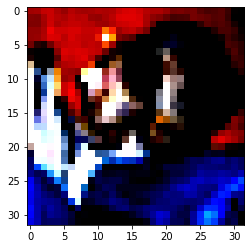

In [16]:
plt.imshow(images_batch[0].permute(1, 2, 0)) # (C, H, W) -> (H, W, C) for visualization 

In [17]:
predictions = AgentDL.predict(images_batch)
pred_label = np.argmax(predictions, axis=1)

print(type(predictions))
print(predictions.shape)
print(f"label = {pred_label}")

<class 'numpy.ndarray'>
(32, 10)
label = [3 8 8 8 6 6 9 4 5 9 5 9 3 7 9 6 5 3 8 6 9 0 8 9 4 4 5 2 9 6 6 5]


In [ ]:
AgentDL.remove_hooks()

### Visualizing filters 

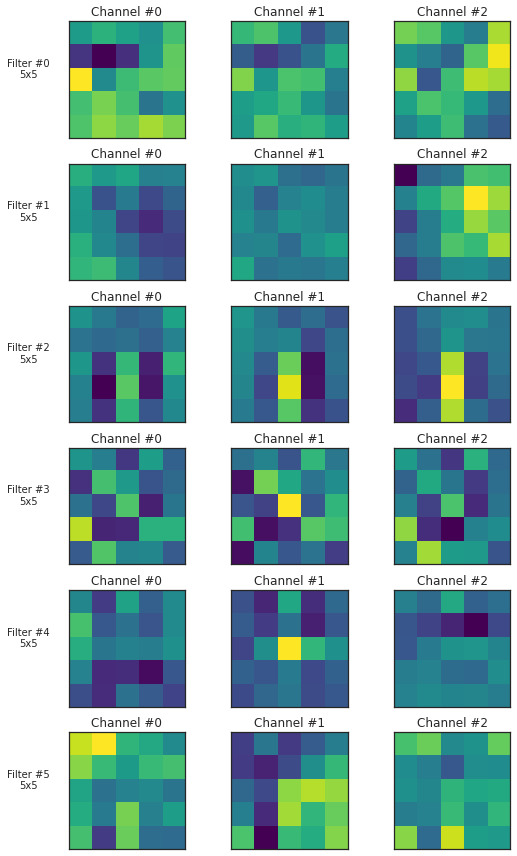

In [18]:
with plt.style.context('seaborn-white'):
    fig = AgentDL.visualize_filters('c1', cmap='viridis')

### Visualizing Feature Maps 

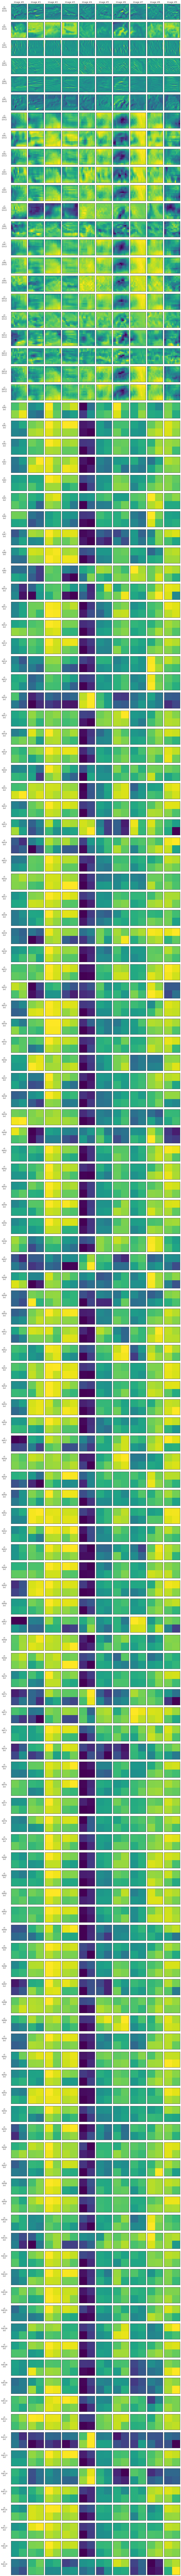

In [19]:
featurizer_layers = ['c1', 'c3', 'c5']


with plt.style.context('seaborn-white'):
    fig = AgentDL.visualize_outputs(featurizer_layers)

### Visualizing Classifier Layers 

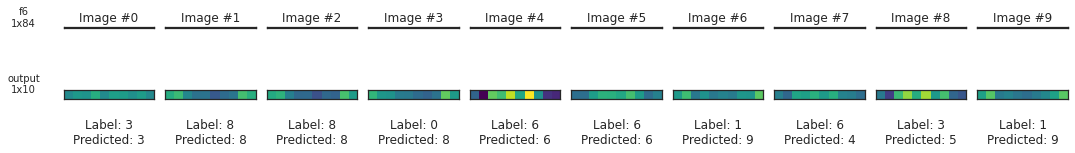

In [20]:
classifier_layers = ['f6', 'output']


with plt.style.context('seaborn-white'):
    fig = AgentDL.visualize_outputs(classifier_layers, y=labels_batch, yhat=pred_label)